In [1]:
# Установим зависимости
!pip install opencv-python matplotlib pandas torch torchvision tqdm

error: externally-managed-environment

× This environment is externally managed
╰─> To install Python packages system-wide, try 'pacman -S
    python-xyz', where xyz is the package you are trying to
    install.
    
    If you wish to install a non-Arch-packaged Python package,
    create a virtual environment using 'python -m venv path/to/venv'.
    Then use path/to/venv/bin/python and path/to/venv/bin/pip.
    
    If you wish to install a non-Arch packaged Python application,
    it may be easiest to use 'pipx install xyz', which will manage a
    virtual environment for you. Make sure you have python-pipx
    installed via pacman.

note: If you believe this is a mistake, please contact your Python installation or OS distribution provider. You can override this, at the risk of breaking your Python installation or OS, by passing --break-system-packages.
hint: See PEP 668 for the detailed specification.


In [2]:
from pathlib import Path

import cv2
import matplotlib.pyplot as plt
import pandas as pd

In [3]:
import warnings
warnings.filterwarnings("ignore")

### Оценим данные

In [4]:
root_data_folder = Path("imagenette2-160")

In [5]:
data = pd.read_csv(root_data_folder / "noisy_imagenette.csv")[["path", "noisy_labels_0"]]

In [6]:
classes_examples_paths = list(data.drop_duplicates("noisy_labels_0")["path"])

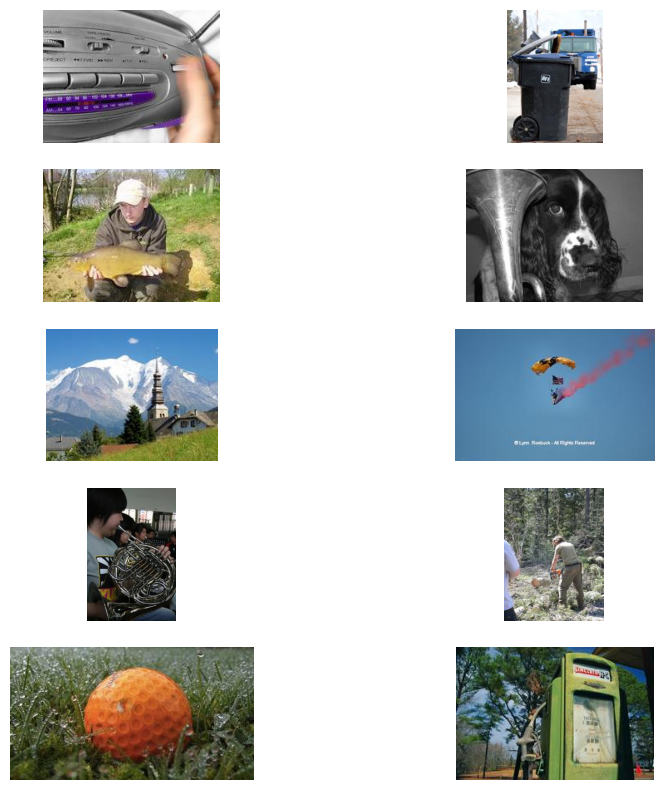

In [7]:
figure = plt.figure(figsize=(10, 10))
cols, rows = 2, 5

for i in range(1, cols * rows + 1):
    img = cv2.imread((root_data_folder / classes_examples_paths[i - 1]).as_posix())[..., ::-1]
    figure.add_subplot(rows, cols, i)
    plt.axis("off")
    plt.imshow(img)

plt.show()

### Инициализируем модель, датасет и оптимизатор

In [8]:
import torch
import torch.nn as nn

from tqdm import tqdm
from torchvision import datasets, transforms
from torch.utils.data import DataLoader

In [12]:
# Выбираем модель
model = torch.hub.load('pytorch/vision:v0.10.0', 'mobilenet_v2', pretrained=True)
model.eval()

criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.classifier.parameters())

Using cache found in /home/cerberus/.cache/torch/hub/pytorch_vision_v0.10.0


In [13]:
# Если берем готовую модель, то меняем голову на нужное количество классов
head = nn.Sequential()

model.classifier = head

In [22]:
# Прописываем трансформы для трейновых и тестовых данных, добавляем аугментации
train_transforms = transforms.Compose([
    transforms.Resize(size=(224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(
        mean=[0.485, 0.456, 0.406],
        std=[0.229, 0.224, 0.225]
    )
])

val_transforms = transforms.Compose([
    transforms.Resize(size=(224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(
        mean=[0.485, 0.456, 0.406],
        std=[0.229, 0.224, 0.225]
    )
])

In [23]:
train_dataset = datasets.ImageFolder((root_data_folder / "train").as_posix(), transform=train_transforms)
eval_dataset = datasets.ImageFolder((root_data_folder / "val").as_posix(), transform=val_transforms)

In [24]:
# Прописываем True или False для перемешивания данных в даталоадере
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
eval_loader = DataLoader(eval_dataset, batch_size=32, shuffle=False)

In [25]:
# Выбираем оптимизатор
optimizer = torch.optim.SGD(model.parameters(), lr=1e-3, momentum = 0.9)

# Задаем лосс-функцию
criterion = nn.CrossEntropyLoss()

# Поменяем девайс, если есть доступ к видеокарте
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [26]:
model.to(device).train();

In [27]:
num_epochs = 10

In [28]:
for epoch_num in range(1, num_epochs + 1):
    running_loss = 0.0
    for images, labels in tqdm(train_loader, total=len(train_loader)):
        # Трейновая часть
        optimizer.zero_grad()
        output = model(images)
        loss = criterion(output.to(device), labels)
        loss.backward()  
        optimizer.step()
    
    with torch.no_grad():
        train_loss = running_loss / len(train_loader)

    # После каждой эпохи сделать вывод метрики Accuracy
    total = 0.0
    correct = 0.0
    model.eval()
    for images, labels in tqdm(eval_loader, total=len(eval_loader)):
        # Тестовая часть
        with torch.no_grad(): 
                outputs = model(images.to(device)) 
                _, predicted = torch.max(outputs.data, 1)
                total += labels.size(0)
                correct += (predicted == labels.to(device)).sum().item()
        
    print('Accuracy: %d %%' % (100 * correct / total))

100%|██████████| 123/123 [01:04<00:00,  1.91it/s]


Accuracy: 88 %


100%|██████████| 123/123 [01:04<00:00,  1.90it/s]


Accuracy: 91 %


100%|██████████| 123/123 [01:02<00:00,  1.96it/s]


Accuracy: 92 %


100%|██████████| 123/123 [01:05<00:00,  1.89it/s]


Accuracy: 94 %


100%|██████████| 123/123 [01:02<00:00,  1.96it/s]


Accuracy: 95 %


100%|██████████| 123/123 [01:02<00:00,  1.97it/s]


Accuracy: 95 %


100%|██████████| 123/123 [01:02<00:00,  1.98it/s]


Accuracy: 94 %


100%|██████████| 123/123 [01:16<00:00,  1.60it/s]


Accuracy: 95 %


100%|██████████| 123/123 [01:13<00:00,  1.67it/s]


Accuracy: 95 %


100%|██████████| 123/123 [01:21<00:00,  1.51it/s]

Accuracy: 95 %


In [29]:
torch.save(model.state_dict(), 'mobilenet_v2_trained_1.pth')